Loaded dataset shape: (200, 5)
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
       CustomerID  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean   100.500000           60.560000               50.200000
std     57.879185           26.264721               25.823522
min      1.000000           15.000000                1.000000
25%     50.750000           41.500000               34.750000
50%    100.500000           61.500000               50.000000
75%    150.250000           78.000000               73.000000
max    200.000000          137.000000          

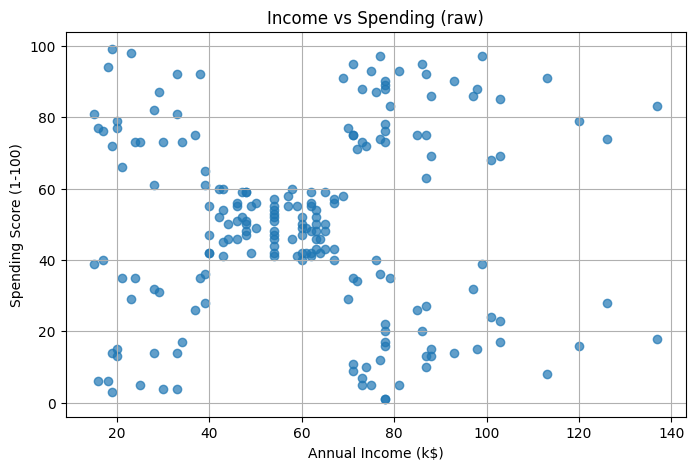

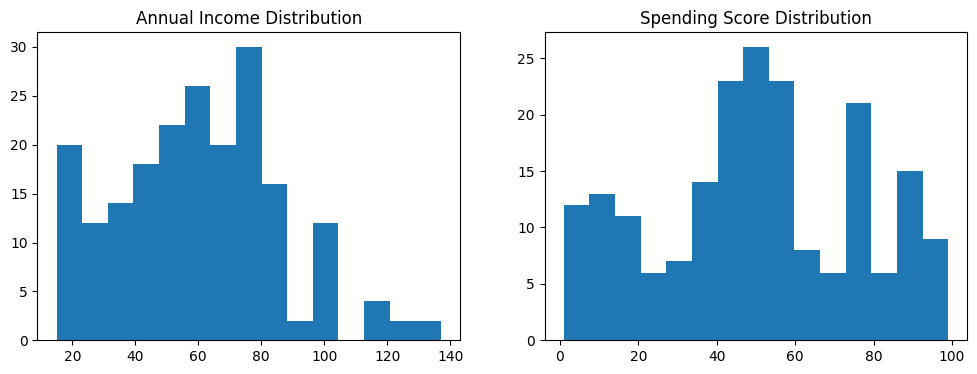

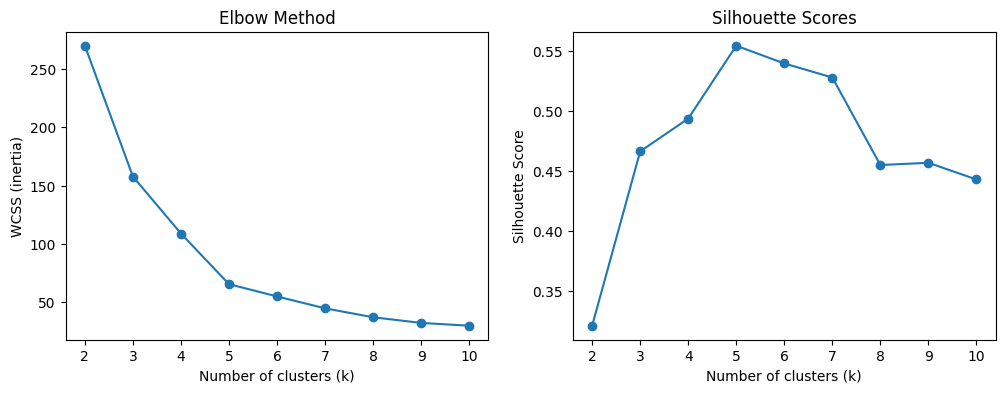

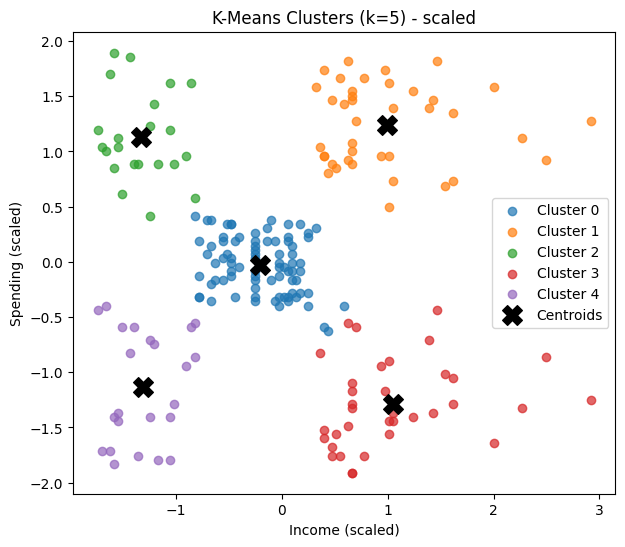

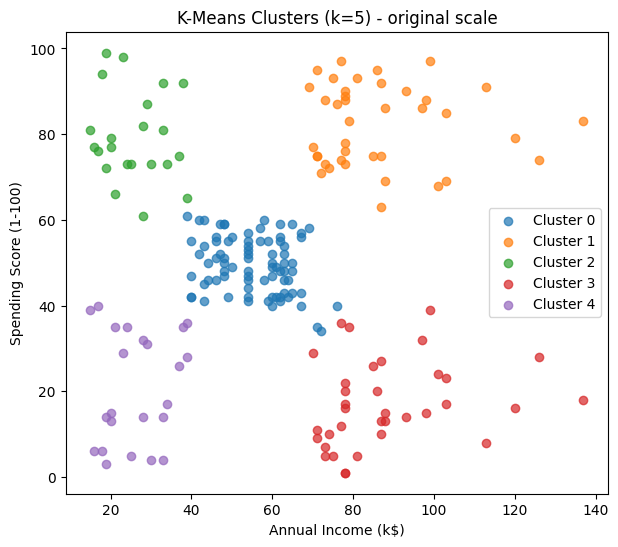

   Cluster  Avg Income (k$)  Avg Spending Score
0        0        55.296296           49.518519
1        1        86.538462           82.128205
2        2        25.727273           79.363636
3        3        88.200000           17.114286
4        4        26.304348           20.913043


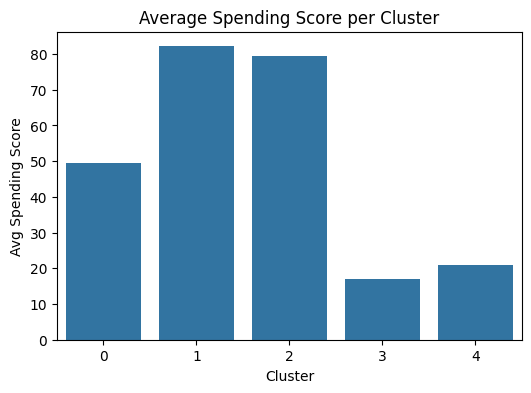

DBSCAN labels found: [-1  0]


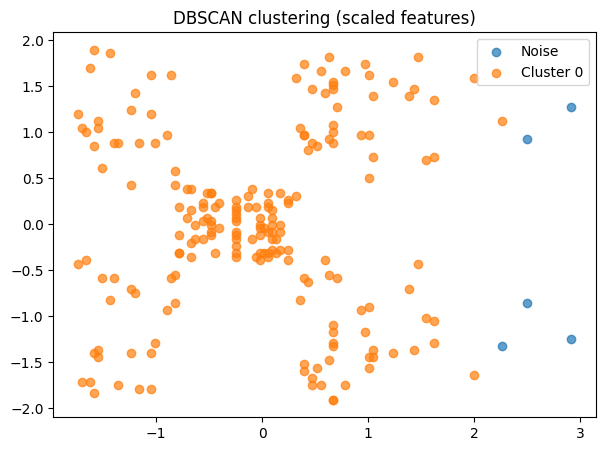

In [2]:
# Task 2 — Customer Segmentation (Google Colab ready)
# --------------------------------------------------
# Colab-friendly notebook script for customer segmentation using the Mall
# It includes:
# - Data loading (upload or Kaggle API option)
# - EDA and scatter plots
# - Feature scaling
# - Elbow method and silhouette scores to pick K
# - K-Means clustering and 2D visualizations (scaled + original)
# - Average spending per cluster
# - Bonus: DBSCAN clustering

# %%
# Install (Colab typically has these already)
!pip install -q scikit-learn pandas matplotlib seaborn

# %% [markdown]
# ## 1) Setup & Load Data
# Place `Mall_Customers.csv` in the Colab session (Files panel) or in Google Drive.

# %%
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

DATA_FILENAME = 'Mall_Customers.csv'

if os.path.exists(DATA_FILENAME):
    df = pd.read_csv(DATA_FILENAME)
else:
    drive_path = '/content/drive/MyDrive/' + DATA_FILENAME
    if os.path.exists(drive_path):
        df = pd.read_csv(drive_path)
    else:
        raise FileNotFoundError(
            f"{DATA_FILENAME} not found.\nUpload Mall_Customers.csv to the Colab session or put it in Drive.")

print('Loaded dataset shape:', df.shape)
print(df.head())

# %% [markdown]
# ## 2) Quick EDA & Feature Selection
# We'll use 'Annual Income (k$)' and 'Spending Score (1-100)'.

# %%
# Normalize column names if needed
col_map = {}
for c in df.columns:
    lc = c.lower()
    if 'income' in lc and 'annual' in lc:
        col_map[c] = 'Annual Income (k$)'
    if 'spend' in lc or 'spending' in lc:
        col_map[c] = 'Spending Score (1-100)'
    if 'customer' in lc and 'id' in lc:
        col_map[c] = 'CustomerID'

if col_map:
    df = df.rename(columns=col_map)

required_cols = ['CustomerID','Annual Income (k$)','Spending Score (1-100)']
if not all(c in df.columns for c in required_cols):
    raise KeyError('Dataset must include CustomerID, Annual Income (k$), and Spending Score (1-100) columns.')

df_seg = df[required_cols].copy()
print(df_seg.describe())

# %% [markdown]
# ## 3) Visual Exploration

# %%
plt.figure(figsize=(8,5))
plt.scatter(df_seg['Annual Income (k$)'], df_seg['Spending Score (1-100)'], alpha=0.7)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Income vs Spending (raw)')
plt.grid(True)
plt.show()

# %%
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(df_seg['Annual Income (k$)'], bins=15)
ax[0].set_title('Annual Income Distribution')
ax[1].hist(df_seg['Spending Score (1-100)'], bins=15)
ax[1].set_title('Spending Score Distribution')
plt.show()

# %% [markdown]
# ## 4) Scaling
# Clustering needs features on similar scales. We'll use StandardScaler.

# %%
scaler = StandardScaler()
X = df_seg[['Annual Income (k$)', 'Spending Score (1-100)']].values
X_scaled = scaler.fit_transform(X)

# %% [markdown]
# ## 5) Determine optimal K (Elbow + Silhouette)

# %%
wcss = []
sil_scores = []
K_range = range(2,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (inertia)')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.show()

# %% [markdown]
# ## 6) Fit K-Means and Visualize
# Set CHOSEN_K based on the plots above. Common choice for this dataset is k=5.

# %%
CHOSEN_K = 5
kmeans = KMeans(n_clusters=CHOSEN_K, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df_seg['Cluster'] = labels

# Plot in scaled space
plt.figure(figsize=(7,6))
palette = sns.color_palette('tab10', CHOSEN_K)
for i in range(CHOSEN_K):
    mask = df_seg['Cluster'] == i
    plt.scatter(X_scaled[mask,0], X_scaled[mask,1], label=f'Cluster {i}', alpha=0.7)
# centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0], centroids[:,1], marker='X', s=200, c='black', label='Centroids')
plt.xlabel('Income (scaled)')
plt.ylabel('Spending (scaled)')
plt.title(f'K-Means Clusters (k={CHOSEN_K}) - scaled')
plt.legend()
plt.show()

# Plot in original scale for interpretability
plt.figure(figsize=(7,6))
for i in range(CHOSEN_K):
    mask = df_seg['Cluster'] == i
    plt.scatter(df_seg.loc[mask,'Annual Income (k$)'], df_seg.loc[mask,'Spending Score (1-100)'], label=f'Cluster {i}', alpha=0.7)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title(f'K-Means Clusters (k={CHOSEN_K}) - original scale')
plt.legend()
plt.show()

# %% [markdown]
# ## 7) Analyze average spending and income per cluster

# %%
cluster_summary = df_seg.groupby('Cluster')[['Annual Income (k$)','Spending Score (1-100)']].mean().reset_index()
cluster_summary = cluster_summary.rename(columns={'Annual Income (k$)':'Avg Income (k$)', 'Spending Score (1-100)':'Avg Spending Score'})
print(cluster_summary)

plt.figure(figsize=(6,4))
sns.barplot(x='Cluster', y='Avg Spending Score', data=cluster_summary)
plt.title('Average Spending Score per Cluster')
plt.show()

# %% [markdown]
# ## 8) Bonus: DBSCAN
# DBSCAN may find noise points; you can tune eps and min_samples.

# %%
dbscan = DBSCAN(eps=0.6, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)
unique = np.unique(db_labels)
print('DBSCAN labels found:', unique)

plt.figure(figsize=(7,5))
for lbl in unique:
    mask = db_labels == lbl
    label_name = 'Noise' if lbl == -1 else f'Cluster {lbl}'
    plt.scatter(X_scaled[mask,0], X_scaled[mask,1], label=label_name, alpha=0.7)
plt.legend()
plt.title('DBSCAN clustering (scaled features)')
plt.show()

# Map DBSCAN labels back if desired
df_seg['DBSCAN_Cluster'] = db_labels

# %% [markdown]
# ## 9) Save segmented data (optional)
# If you want to save the clustered output in Colab session or Drive, uncomment below.

# %%
# OUT_CSV = 'mall_customers_segmented.csv'
# df_seg.to_csv(OUT_CSV, index=False)
# print('Saved', OUT_CSV)

# %% [markdown]
# ## End of notebook

